# Stanford Drone Dataset (SDD)

The following tests contain the evaluation of Explainable Boosting Machines (EBM) on [SDD](https://cvgl.stanford.edu/projects/uav_data/) pedestrains forcasting dataset. 
Interestingly, without dense road network data, the model give 14.70 pixel of final error for 20 modes ([State-of-the-art](https://paperswithcode.com/sota/trajectory-prediction-on-stanford-drone) give 6.52 pixel).

The code assume existance of InD dataset files extracted in a neighbour folder.

Lastly, a forword neural network is trained. However, it is noted the results are worse for single mode case (43 for NN, and 30 for EBM)

In [1]:
import numpy as np
from pygam import LinearGAM, s, f,l,te
from utils import *
from matplotlib import pyplot as plt
from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor

import glob,os
%matplotlib inline

# Load train split

`Xs = 7*2 = 14 for x,y flattened of 7 points of input ==>3.2 second + (w,h)*8 +(lost,occ,gen)+type`


`Ys = step20 x,y (roated +transationed)`


`Nx = point7 , rtatoion measure, flipatoion measure (std of angles), (lost,occ,gen)`

**load dataset from text files or from .npy files if processed already**

In [2]:

if os.path.isfile('yx_all_n.npy'):
    yx_all = np.load('yx_all_n.npy')
else:
    train_files_ = glob.glob('data/train/**',recursive=True)
    val_files_ = glob.glob('data/val/**',recursive=True)
    ds_list = [os.path.join(f,'annotations.txt') for f in train_files_+val_files_ if ('video' in f) and os.path.isdir(f)]

    train_ds = list(map(lambda x: tracks_to_array(read_sdd(x)),ds_list))
    yx_all = np.vstack(tuple([np.hstack((ds[1],ds[0])) for ds in train_ds]))
    np.save('yx_all_n.npy',yx_all)
    
print(yx_all.shape)

(585856, 36)


# Load test split

In [3]:
if os.path.isfile('yx_test_all_n.npy'):
    yx_test_all = np.load('yx_test_all_n.npy')
else:
    test_files_ = glob.glob('data/test/**',recursive=True)
    ds_list = [os.path.join(f,'annotations.txt') for f in test_files_ if ('video' in f) and os.path.isdir(f)]
    test_ds = list(map(lambda x: tracks_to_array(read_sdd(x)),ds_list))

    yx_test_all = np.vstack(tuple([np.hstack((ds[1],ds[0])) for ds in test_ds]))
    
    np.save('yx_test_all_n.npy',yx_test_all)
    
print(yx_test_all.shape)

(143582, 36)


## Print types percentage

In [4]:
traffic_entites = ['Pedestrian','Skater','Biker','Cart','Bus','Car'] 
for i in range(6):
    entity_percent = sum(yx_all[:,-1]==i)/(yx_all.shape[0])
    print(f'{traffic_entites[i]}: {entity_percent}')

Pedestrian: 0.5609945105964605
Skater: 0.011700827507100721
Biker: 0.31037319750928555
Cart: 0.008401381909547739
Bus: 0.0061226649552108365
Car: 0.10240741752239459


## Filter the type


In [5]:
# backup copy
yx_all_ = yx_all.copy()
yx_test_all_ = yx_test_all.copy()

In [6]:
# {'Pedestrian':0, 'Car':5,'Bus':4, 'Biker':2, 'Cart':3, 'Skater':1}
TYPE = 0

yx_all = yx_all_[yx_all_[:,-1]==TYPE][:,:-1]
yx_test_all = yx_test_all_[yx_test_all_[:,-1]==TYPE][:,:-1]

print(yx_all.shape)
print(yx_test_all.shape)

(328662, 35)
(92688, 35)


# Split the target varaible into 20 modes
given that

In [7]:
print(yx_all.shape)
y_xrange = [yx_all[:,0].min(),yx_all[:,0].max()]
y_yrange = [yx_all[:,1].min(),yx_all[:,1].max()]
print(f'xmax: {yx_all[:,0].max()} and xmin: {yx_all[:,0].min()}')
print(f'ymax: {yx_all[:,1].max()} and ymin: {yx_all[:,1].min()}')

(328662, 35)
xmax: 1124.5 and xmin: -1380.5127777068074
ymax: 881.0 and ymin: -1272.215382071125


# masking

In [8]:
mask0 = (yx_all[:,0]<800)*(yx_all[:,0]>-800)*(yx_all[:,1]<500)*(yx_all[:,1]>-500)# x800,y500
# noisy
mask0 *= (yx_all[:,12]>-200)
full_len = yx_all.shape[0]
yx_all = yx_all[mask0]
y_xrange = [yx_all[:,0].min(),yx_all[:,0].max()]
y_yrange = [yx_all[:,1].min(),yx_all[:,1].max()]
print(f'Outliers percent: {(full_len-yx_all.shape[0])/full_len}')

Outliers percent: 0.0005324619213660234


## Draw traget varaible

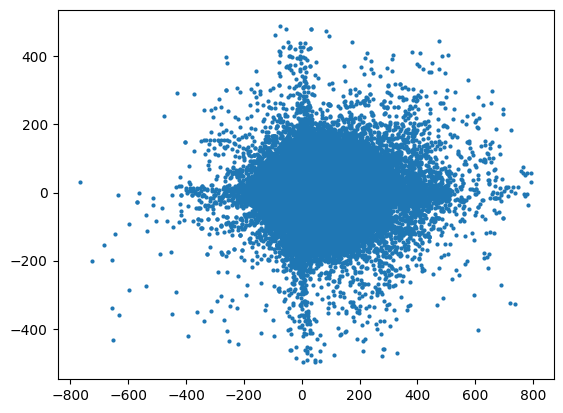

In [9]:
sub_modes = []
plt.scatter(yx_all[:,0],yx_all[:,1],marker='.',linewidths=0.001)
plt.show()

# Kmeans Clustering

In [10]:
from sklearn.cluster import KMeans
modes_n = 36
clusterer = KMeans(n_clusters=modes_n,random_state=42).fit(yx_all[:,:2])#,n_init=10

c:\Users\yasin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


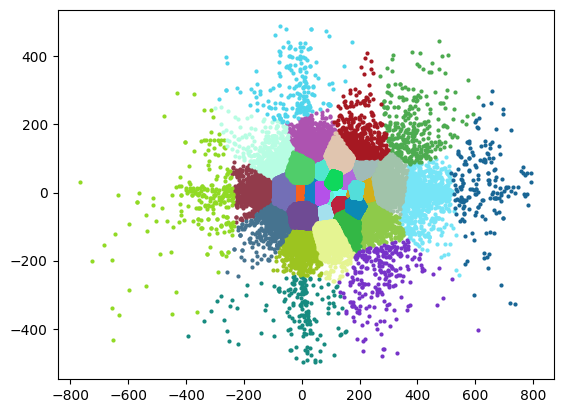

In [11]:
sub_modes = []
for i in range(modes_n):
    cluster_i = (clusterer.labels_==i)
    #print(sum(cluster_i))
    #if (sum(cluster_i))>1000:
    sub_modes.append(yx_all[cluster_i])
    color = np.array([[np.random.rand() for _  in range(3)]])
    plt.scatter(yx_all[cluster_i][:,0],yx_all[cluster_i][:,1],c=color,marker='.',linewidths=0.001)
plt.show()

4 ranges on xs

5 ranges on ys

Each has the same number of samples (by sorting first then deviding)

In [71]:
if len(sub_modes)==0:
    x_ranges = 5

    yx_sorted_x = sorted(yx_all,key=lambda x: x[0])
    single_len = (len(yx_sorted_x)//x_ranges)+(x_ranges-1)
    sub_modes_x = [yx_sorted_x[(i*single_len):(i+1)*single_len] for i in range(x_ranges)]

    y_ranges = 4

    for sub_mode_x in sub_modes_x:
        yx_sorted_y = sorted(sub_mode_x,key=lambda x: x[1])
        single_len = (len(yx_sorted_y)//y_ranges)+(y_ranges-1)
        sub_modes.extend([np.array(yx_sorted_y[(i*single_len):(i+1)*single_len]) for i in range(y_ranges)])

# Set feature names

In [33]:
f_names = []
for x in range(7):
    f_names.extend([f'x_{x}',f'y_{x}'])
for x in range(8):
    f_names.extend([f'w_{x}',f'h_{x}'])

f_names += ['losts','occluded','generated']

# Train GAM without finetunning (Xs)

In [34]:
GAMs_x = []
for i,mode in enumerate(sub_modes):
    if len(mode)==0: continue
    gam = ExplainableBoostingRegressor(feature_names=f_names).fit((mode[:,2:]),(mode[:,0]))
    print(f'mode {i} trained')
    GAMs_x.append(gam)


mode 0 trained
mode 1 trained
mode 2 trained
mode 3 trained
mode 4 trained
mode 5 trained
mode 6 trained
mode 7 trained
mode 8 trained
mode 9 trained
mode 10 trained
mode 11 trained
mode 12 trained
mode 13 trained
mode 14 trained
mode 15 trained
mode 16 trained
mode 17 trained
mode 18 trained
mode 19 trained
mode 20 trained
mode 21 trained
mode 22 trained
mode 23 trained
mode 24 trained
mode 25 trained
mode 26 trained
mode 27 trained
mode 28 trained
mode 29 trained
mode 30 trained
mode 31 trained
mode 32 trained
mode 33 trained
mode 34 trained
mode 35 trained


In [35]:
errors = [abs(gam_.predict((yx_test_all[:,2:]))-yx_test_all[:,0]) for gam_ in GAMs_x]

print('error for each single mode')
for i,error in enumerate(errors):
    print(f'mode {i} error: {error.mean()}')

print('MinFDEx')
min_errorsx=np.sort(np.vstack(tuple(errors)).T,axis=1)
x_error = min_errorsx[:,0].mean()
print(x_error)

error for each single mode
mode 0 error: 95.74725789886588
mode 1 error: 97.54252592744933
mode 2 error: 82.33461313370087
mode 3 error: 86.13766077001152
mode 4 error: 304.35862496663066
mode 5 error: 233.41339717474358
mode 6 error: 82.05268719259287
mode 7 error: 115.4460642027292
mode 8 error: 140.3511764230002
mode 9 error: 102.8076074284307
mode 10 error: 89.44035420586839
mode 11 error: 159.32634416348898
mode 12 error: 92.53375628060314
mode 13 error: 72.18256462672166
mode 14 error: 89.5342968309623
mode 15 error: 404.41298607069183
mode 16 error: 273.82485875164974
mode 17 error: 88.01929860056015
mode 18 error: 86.08674080676809
mode 19 error: 94.85348340978017
mode 20 error: 197.39025012498735
mode 21 error: 114.83622958974394
mode 22 error: 82.97882734924266
mode 23 error: 193.90123668056066
mode 24 error: 188.39903172615575
mode 25 error: 91.11826101825199
mode 26 error: 152.68632043909173
mode 27 error: 526.9071122409815
mode 28 error: 107.71813734242481
mode 29 error: 1

In [36]:
GAMs_y = []
for i,mode in enumerate(sub_modes):
    if len(mode)==0: continue
    gam = ExplainableBoostingRegressor(feature_names=f_names).fit((mode[:,2:]),(mode[:,1]))
    print(f'mode {i} trained')
    GAMs_y.append(gam)



mode 0 trained
mode 1 trained
mode 2 trained
mode 3 trained
mode 4 trained
mode 5 trained
mode 6 trained
mode 7 trained
mode 8 trained
mode 9 trained
mode 10 trained
mode 11 trained
mode 12 trained
mode 13 trained
mode 14 trained
mode 15 trained
mode 16 trained
mode 17 trained
mode 18 trained
mode 19 trained
mode 20 trained
mode 21 trained
mode 22 trained
mode 23 trained
mode 24 trained
mode 25 trained
mode 26 trained
mode 27 trained
mode 28 trained
mode 29 trained
mode 30 trained
mode 31 trained
mode 32 trained
mode 33 trained
mode 34 trained
mode 35 trained


In [37]:
errorsy = [abs(gam_.predict(yx_test_all[:,2:])-yx_test_all[:,1]) for gam_ in GAMs_y]

print('error for each single mode')
for i,error in enumerate(errorsy):
    print(f'mode {i} error: {error.mean()}')

print('MinFDEy')
min_errorsy=np.sort(np.vstack(tuple(errorsy)).T,axis=1)
y_error = min_errorsy[:,0].mean()
print(y_error)

error for each single mode
mode 0 error: 20.3707824015069
mode 1 error: 21.317525304915034
mode 2 error: 55.06480985952739
mode 3 error: 21.798527511989285
mode 4 error: 44.66159600194827
mode 5 error: 25.836530227075194
mode 6 error: 62.91471053341418
mode 7 error: 61.48639703906286
mode 8 error: 20.871172740076183
mode 9 error: 339.5235524165844
mode 10 error: 20.576163768954885
mode 11 error: 78.29026752970078
mode 12 error: 150.07228160002794
mode 13 error: 139.9585524393946
mode 14 error: 20.833986965408563
mode 15 error: 61.386148305086046
mode 16 error: 167.15415874904724
mode 17 error: 40.78038396577664
mode 18 error: 20.577542826532685
mode 19 error: 41.89748909149765
mode 20 error: 29.434504730719347
mode 21 error: 153.50505740853833
mode 22 error: 94.86655690488193
mode 23 error: 92.85673929809286
mode 24 error: 82.15420948651999
mode 25 error: 84.96843683417096
mode 26 error: 24.431316332189656
mode 27 error: 59.901884616504994
mode 28 error: 40.92688299261945
mode 29 error

In [59]:
ecl_dists = [np.sqrt((err_x**2)+(err_y**2)) for err_x,err_y in zip(errors,errorsy)]
min_errors_ecl=np.sort(np.vstack(tuple(ecl_dists)).T,axis=1)
xy_error = min_errors_ecl[:,0].mean()
print(xy_error)

13.294623134131228


In [60]:
#np.array([f[1] for f in best_f if (f[1])])
from scipy import stats
 
def get_std(model):
    all_devs = 0
    for m in model.standard_deviations_:
        if len(m.shape)>1:
            all_devs += m.mean(axis=0).mean(axis=0)
        else:
            all_devs += m.mean(axis=0)
    return all_devs

# Single GAM

In [13]:
if os.path.isfile('ind_gam_allx_') :
    gam_allx = ExplainableBoostingRegressor()._from_json(f'sdd_gam_allx_{TYPE}')
    gam_ally = ExplainableBoostingRegressor()._from_json(f'sdd_gam_ally_{TYPE}')
else:
    gam_allx = ExplainableBoostingRegressor(feature_names=f_names).fit(yx_all[:,2:],yx_all[:,0])
    print('done training on x axis')
    gam_allx.to_json(f'sdd_gam_allx_{TYPE}')
    gam_ally = ExplainableBoostingRegressor(feature_names=f_names).fit(yx_all[:,2:],yx_all[:,1])
    print('done training on y axis')
    gam_ally.to_json(f'sdd_gam_ally_{TYPE}')

c:\Users\yasin\AppData\Local\Programs\Python\Python310\lib\site-packages\interpret\glassbox\_ebm\_json.py:407: UserWarning: JSON formats are in beta. The JSON format may change in a future version without compatibility between releases.
  warn(


In [14]:
errorsx = abs(gam_allx.predict(yx_test_all[:,2:])-yx_test_all[:,0]) 

print('MinFDEx')
print(f'all error: {errorsx.mean()}')

MinFDEx
all error: 30.74622007828169


In [15]:
errorsy = abs(gam_ally.predict(yx_test_all[:,2:])-yx_test_all[:,1]) 

print('MinFDEx')
print(f'all error: {errorsy.mean()}')

print(f'final error: {np.linalg.norm([errorsx.mean(),errorsy.mean()])}')

MinFDEx
all error: 20.60347593824397
final error: 37.01125869029491


In [86]:
loglikelihoods = []
probs = []
all_preds = []
global_preds = []
global_std = get_std(gam_allx)
for m,gam in enumerate(GAMs_x):
    predsx = gam.predict(yx_test_all[:,2:])
    all_preds.append(predsx)
    if len(global_preds):
        pass
    else:
        global_preds = gam_allx.predict(yx_test_all[:,2:])
    likely = stats.norm.logpdf(predsx,loc=global_preds,scale=global_std)
    #likely += stats.norm.logpdf(predsx,loc=predsx,scale=get_std(gam))/10

    loglikelihoods.append(likely)

    
    

In [88]:
loglikelihoodsy = []
all_predsy = []
probs_y = []
global_preds = []
global_std = get_std(gam_ally)
for m,gam in enumerate(GAMs_y):
    predsy = gam.predict(yx_test_all[:,2:])
    all_predsy.append(predsy)
    
    if len(global_preds)==0:
        global_preds  =gam_ally.predict(yx_test_all[:,2:])
    likely = stats.norm.logpdf(predsy,loc=global_preds,scale=global_std)
    #likely += stats.norm.logpdf(predsy,loc=predsy,scale=get_std(gam))/2
    
    loglikelihoodsy.append(likely)

In [89]:

n_hoods = np.nan_to_num(np.array(loglikelihoodsy)+np.array(loglikelihoods)*8,nan=-np.inf)
n_hoods_sorted = np.sort(n_hoods.T,axis=1)
top_6y = []
for j in range(20):
    A = n_hoods_sorted[:,-1-j]
    pred = np.array(all_predsy).T[(n_hoods.T == A[:,None])]
    top_6y.append(pred)
    
print(np.sort(abs(np.array(top_6y).T-yx_test_all[:,1:2]),axis=1)[:,0].mean())

top_6 = []
for j in range(20):
    A = n_hoods_sorted[:,-1-j]
    pred = np.array(all_preds).T[(n_hoods.T == A[:,None])]
    top_6.append(pred)
    
print(np.sort(abs(np.array(top_6).T-yx_test_all[:,:1]),axis=1)[:,0].mean())

FDE_errors = np.sqrt((np.array(top_6).T - yx_test_all[:,:1])**2 + (np.array(top_6y).T - yx_test_all[:,1:2])**2)
np.sort(FDE_errors,axis=1)[:,0].mean()

4.023314099053314
5.343916359959934


14.706631986773074

# Explanation

In [16]:
global_ex_x  = gam_allx.explain_global()
global_ex_y  = gam_ally.explain_global()

local_ex_x = gam_allx.explain_local(yx_test_all[:100,2:])
local_ex_y = gam_ally.explain_local(yx_test_all[:100,2:])

show([global_ex_x,local_ex_x])

<!-- http://127.0.0.1:7001/2420887653184/ -->
 Open in new window

# Global Explaination

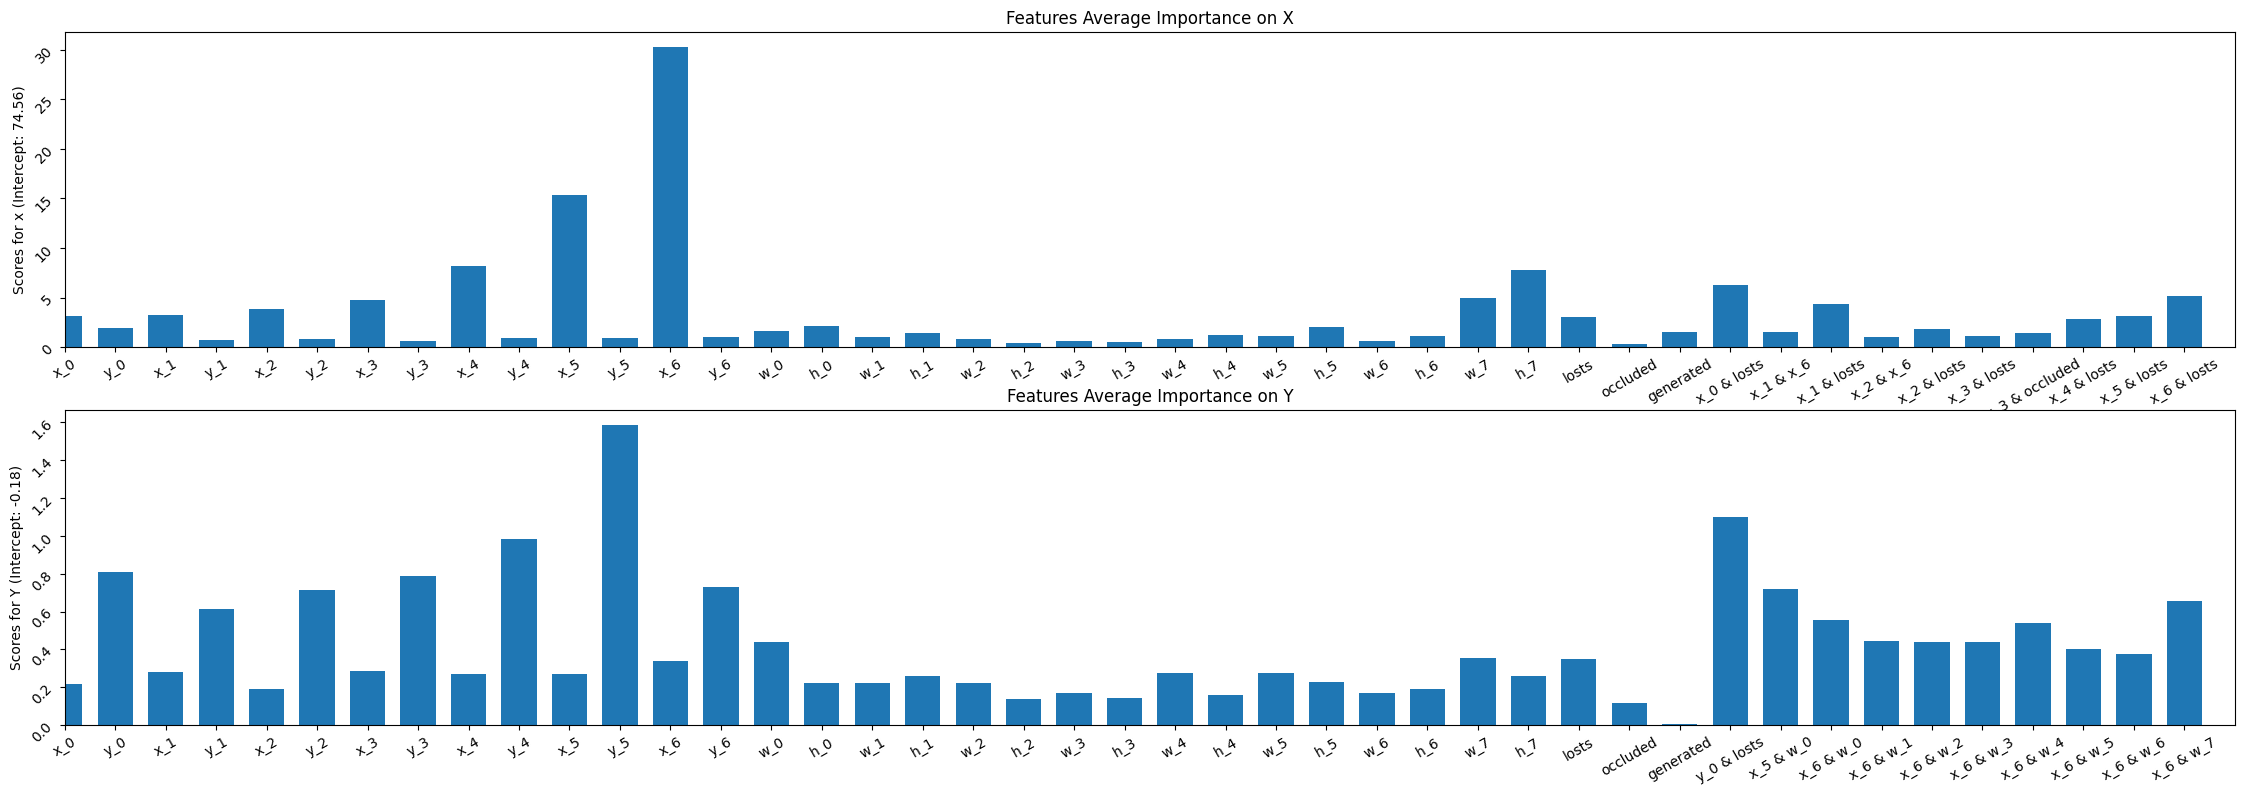

In [26]:
scores = global_ex_x.data()['scores'][0:]
names = global_ex_x.data()['names'][0:]

plt.figure(figsize=(28,9))
plt.subplot(211)
plt.bar(range(0,len(scores)*10,10),scores,width=7,align='center')
plt.xticks(np.arange(0,len(scores)*10,10),names,rotation=30)
plt.xlim(0,len(scores)*10)
plt.yticks(rotation=45)
plt.ylabel(f'Scores for x (Intercept: {np.round(gam_allx.intercept_,2)[0]})')
plt.title('Features Average Importance on X')


scores = global_ex_y.data()['scores'][0:]
names = global_ex_y.data()['names'][0:]

plt.subplot(212)
plt.bar(range(0,len(scores)*10,10),scores,width=7,align='center')
plt.xticks(np.arange(0,len(scores)*10,10),names,rotation=30)
plt.xlim(0,len(scores)*10)
plt.yticks(rotation=45)
plt.ylabel(f'Scores for Y (Intercept: {np.round(gam_ally.intercept_,2)[0]})')
plt.title('Features Average Importance on Y')

plt.show()

In [107]:
yx_all[:,12].min()

-199.32168955465184

# Best 6 Features

In [79]:
f_dict

{'type': 'interaction',
 'left_names': [-721.5,
  -137.00396248136065,
  -121.59444739607139,
  -113.0,
  -106.99989523013656,
  -101.81182579834226,
  -97.85393518791454,
  -94.28216480557461,
  -91.00019796337025,
  -88.11328206769437,
  -85.00157061985638,
  -82.06047856264573,
  -79.00991257024745,
  -76.0000130996717,
  -72.99999999999999,
  -69.50013200423743,
  -65.9995645293099,
  -61.49999999999999,
  -56.51061987759327,
  -50.0,
  -42.99999999999999,
  -33.153141633069666,
  -20.999999999999996,
  -11.660957948721684,
  -6.0,
  -3.0,
  -1.5,
  -1.5308084989341915e-17,
  1.5308084989341915e-17,
  2.0000000000000004,
  608.5],
 'right_names': [0.0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.0],
 'scores': array([[ 1.11026927e+01, -8.02394277e+01, -8.56254591e+01,
         -9.08594080e+01, -8.16817854e+01, -1.10009705e+02,
         -1.14338446e+02, -1.23569860e+02, -1.19135509e+02],
        [ 8.32014962e+00, -6.53278842e+01, -7.07139156e+01,
         -7.59478644e+01, -6.67702419e

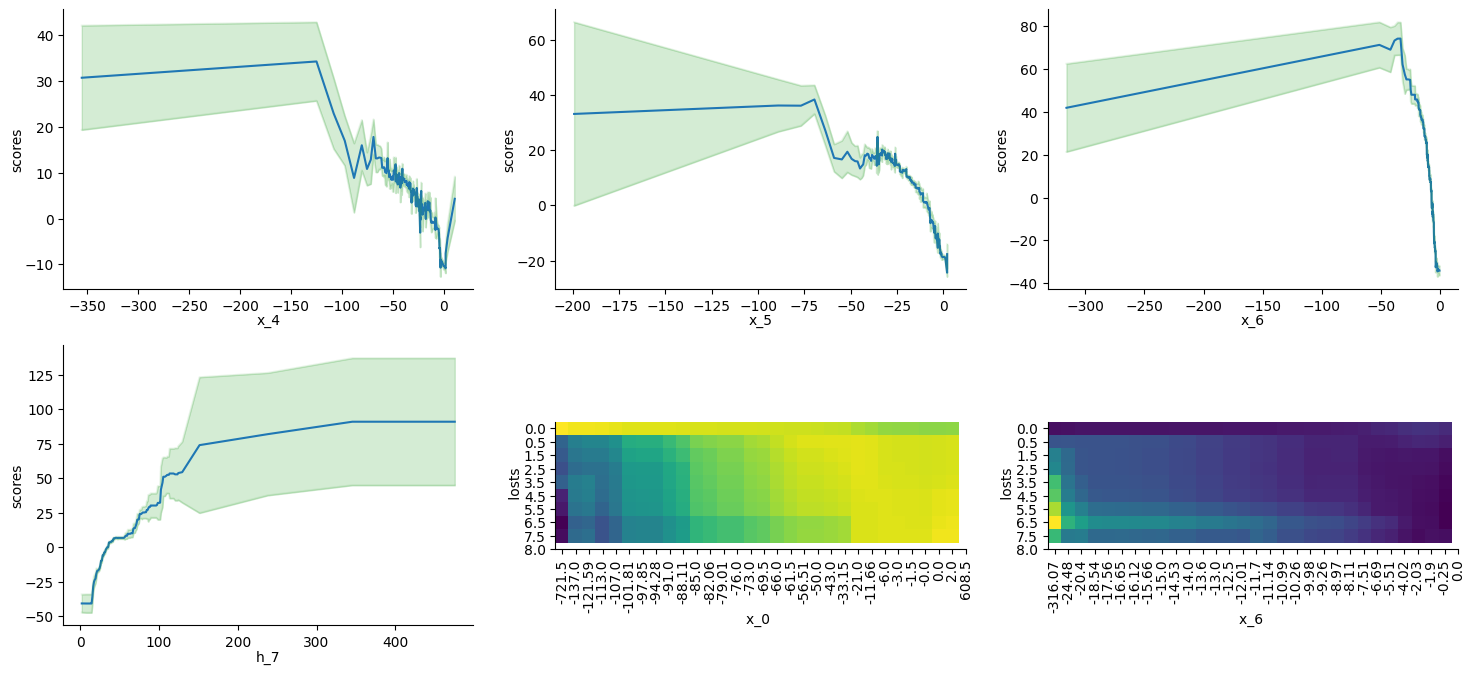

In [28]:
import seaborn as sns
names = global_ex_x.data()['names']
scores = global_ex_x.data()['scores']

best_6_mask = scores>(np.sort(scores)[-7])
p_in = 1
plt.figure(figsize=(18,8))
plt.title('Best six features dependence graphs for X model')
sigma_factor = 3
for k_i in np.arange(len(scores))[best_6_mask]:
    f_dict = global_ex_x.data(key=k_i)
    if f_dict['type']=='interaction':
        ax = plt.subplot(2,3,p_in)
        p_in += 1
        s_data = f_dict['scores'].T
        plt.imshow(s_data)
        ay_l,ax_l = names[k_i].split('&')
        plt.ylabel(ax_l,labelpad=0.5)
        plt.xlabel(ay_l,labelpad=0.1)
        plt.xticks(ticks=np.arange(len(f_dict['left_names'])),labels=np.round(f_dict['left_names'],2),rotation=90)
        plt.yticks(ticks=np.arange(len(f_dict['right_names'])),labels=np.round(f_dict['right_names'],1))
        # TODO heatmap 
    else:
        x_data = f_dict['names'][:-1]
        y_data = f_dict['scores']
        up_data = f_dict['upper_bounds']
        up_data_m = sigma_factor*(up_data-y_data) + y_data
        low_data = f_dict['lower_bounds']
        low_data_m = sigma_factor*(low_data-y_data) + y_data
        ax = plt.subplot(2,3,p_in)
        p_in += 1
        plt.plot(x_data,y_data)
        #plt.plot(x_data,up_data_m ,c='r',ls='--')
        #plt.plot(x_data,low_data_m,c='r',ls='--')
        plt.xlabel(names[k_i],labelpad=0.5)
        plt.ylabel("scores",labelpad=0.1)
        
        ax.plot(x_data, low_data_m, color='tab:green', alpha=0.1)
        ax.plot(x_data, up_data_m, color='tab:green', alpha=0.1)
        ax.fill_between(x_data, low_data_m, up_data_m,color='tab:green', alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

# Best Prediction

In [30]:
def get_all_modes(input_arr):
    
    out = []
    for gamx,gamy in zip(GAMs_x,GAMs_y):
        
        out.append([gamx.predict(input_arr)[0],gamy.predict(input_arr)[0]])
    return np.array(out)

C:\Users\yasin\AppData\Local\Temp\ipykernel_19404\3974029931.py:39: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

C:\Users\yasin\AppData\Local\Temp\ipykernel_19404\3974029931.py:53: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



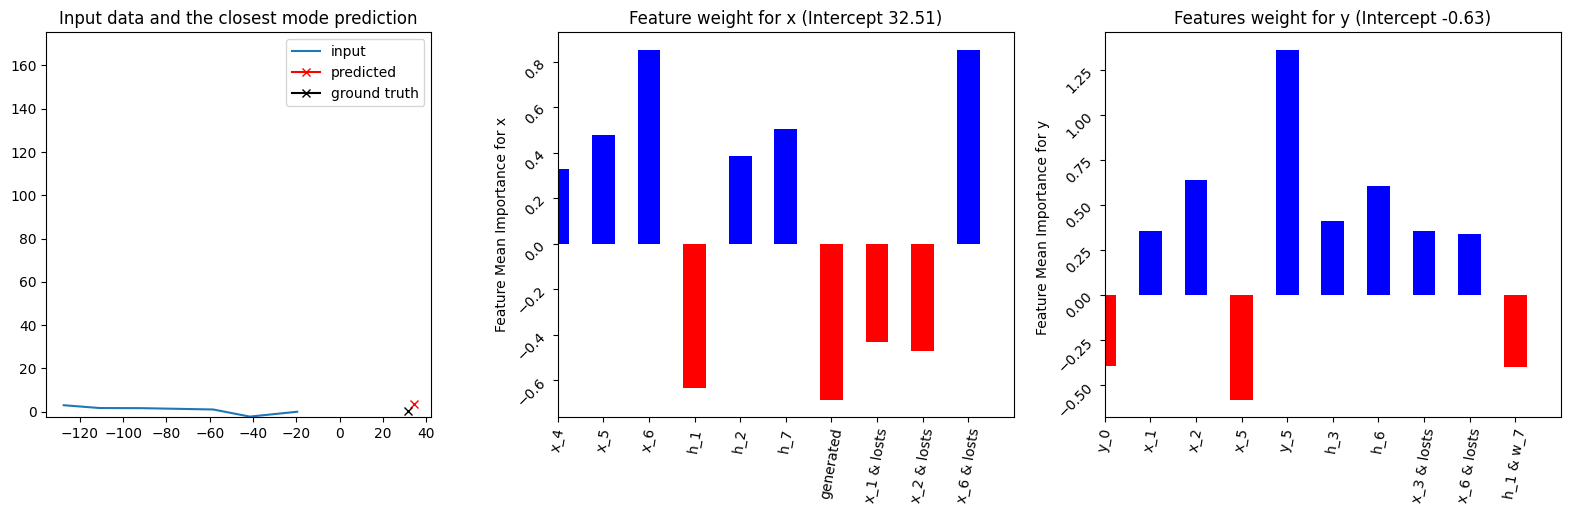

In [52]:

key_ = 140

pred_20 = get_all_modes(yx_test_all[key_,2:])
best_mode = np.linalg.norm(pred_20 - yx_test_all[key_,:2],axis=1).argmin()
local_ex_x_mode = GAMs_x[best_mode].explain_local(yx_test_all[:key_+2,2:])
local_ex_y_mode = GAMs_y[best_mode].explain_local(yx_test_all[:key_+2,2:])

data_x = local_ex_x_mode.data(key=key_)
data_y = local_ex_y_mode.data(key=key_)
names = data_x['names']
input_data = [[],[]]

# draw input 
for s_ in range(7):
    f_ind_x = names.index(f'x_{s_}')
    f_ind_y = names.index(f'y_{s_}')
    input_data[0].append(data_x['values'][f_ind_x])
    input_data[1].append(data_x['values'][f_ind_y])
    
plt.figure(figsize=(20,5))
plt.title(f'global models ex {key_}')
plt.subplot(131)
plt.plot((input_data[0]),input_data[1],label='input')
#draw output
plt.plot(data_x['perf']['predicted'],data_y['perf']['predicted'],marker='x',color='r',label='predicted')
plt.plot(yx_test_all[key_,0],yx_test_all[key_,1],marker='x',color='k',label='ground truth')
plt.legend()
plt.ylim([-1,1])
plt.title('Input data and the closest mode prediction')
plt.axis('square')

#plt.show()

plt.subplot(132)
#draw best 10 amounts to x
scores = np.array(data_x['scores'])
mask_best_6 = np.sort(np.abs(scores))[-11]<np.abs(scores)

plt.bar(range(0,len(scores[mask_best_6])*10,10),scores[mask_best_6],width=5,align='center',color=[['r','b'][x>0] for x in scores[mask_best_6]])
plt.xticks(np.arange(0,len(scores[mask_best_6])*10,10),np.array(names)[mask_best_6],rotation=80)
plt.xlim(0,len(scores[mask_best_6])*10)
plt.yticks(rotation=45)
plt.ylabel('Feature Mean Importance for x')
plt.title(f'Feature weight for x (Intercept {np.round(data_x["extra"]["scores"][0],decimals=2)})')
#plt.ylim([-1,1])
#plt.show()

plt.subplot(133)
#draw best 10 amounts to y
scores = np.array(data_y['scores'])
mask_best_6 = np.sort(np.abs(scores))[-11]<np.abs(scores)

plt.bar(range(0,len(scores[mask_best_6])*10,10),scores[mask_best_6],width=5,align='center',color=[['r','b'][x>0] for x in scores[mask_best_6]])
plt.xticks(np.arange(0,len(scores[mask_best_6])*10,10),np.array(names)[mask_best_6],rotation=80)
plt.xlim(0,len(scores[mask_best_6])*10)
plt.yticks(rotation=45)
plt.ylabel('Feature Mean Importance for y ')
plt.title(f'Features weight for y (Intercept {np.round(data_y["extra"]["scores"][-1],decimals=2)})')
#plt.ylim([-1,1])

plt.show()

# Train NN model

In [125]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.distributions.normal import Normal

In [126]:
class Agent(nn.Module):

    def __init__(self):

        super().__init__()


        self.fc = nn.Linear(yx_all.shape[1]-2,128)
        self.drop_out = nn.Dropout(0.15)
        self.fc_mid = nn.Linear(128,64)
        self.fc_out = nn.Linear(64,2)
        self.fc_std = nn.Linear(64,2)

    def forward(self,vec):

        # xy branch
        x = self.fc(vec)
        x = self.drop_out(x)
        x = self.fc_mid(x)
        mean_ = self.fc_out(x)
        std_ = F.relu(self.fc_std(x))+1e-10
        dist = Normal(mean_,std_)
        return dist.rsample()



# Train

In [135]:


batch = 128
epochs = 25
device = ['cpu','cuda'][torch.cuda.is_available()]
model = Agent().train().to(device)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()




In [136]:
model.train()
for e_ in range(epochs):
    full_train_loss = []
    for i in range(yx_all.shape[0]//batch):
        label,in_ = yx_all[(i*batch):((i+1)*batch),:2],yx_all[(i*batch):((i+1)*batch),2:]

        out = model(torch.as_tensor(in_,device=device).float())


        loss = criterion(out,torch.as_tensor(label,device=device).float())
          
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.07)
        optimizer.step()
        full_train_loss.append(loss.item())
    print(f'Epoch {e_}: full_train_loss: {np.mean(full_train_loss)}')

Epoch 0: full_train_loss: 2011.7492989707719
Epoch 1: full_train_loss: 1943.5768112327935
Epoch 2: full_train_loss: 1934.1174262844763
Epoch 3: full_train_loss: 1923.4234264567785
Epoch 4: full_train_loss: 1924.2951972344288
Epoch 5: full_train_loss: 1928.0019738425617
Epoch 6: full_train_loss: 1920.676403061357
Epoch 7: full_train_loss: 1917.013709889709
Epoch 8: full_train_loss: 1912.838994988453
Epoch 9: full_train_loss: 1914.000968451669
Epoch 10: full_train_loss: 1912.1918719594403
Epoch 11: full_train_loss: 1905.1655955864226
Epoch 12: full_train_loss: 1905.7361458611972
Epoch 13: full_train_loss: 1909.3566903871015
Epoch 14: full_train_loss: 1905.419562590048
Epoch 15: full_train_loss: 1905.0802833958242
Epoch 16: full_train_loss: 1905.8115002317347
Epoch 17: full_train_loss: 1905.524492218173
Epoch 18: full_train_loss: 1903.370015128274
Epoch 19: full_train_loss: 1904.132273752338
Epoch 20: full_train_loss: 1904.9612563504247
Epoch 21: full_train_loss: 1903.1697879754652
Epoch 

# Test

In [137]:
model.eval()
label_test,in_ = yx_test_all[:,:2],yx_test_all[:,2:]
out_test = model(torch.as_tensor(in_,device=device).float()).detach().cpu().numpy()


In [ ]:
label_test.shape

(92688, 2)

In [138]:
FDE = np.linalg.norm(out_test-label_test,axis=1)
print(f'MinFDE: {FDE.mean()}')
# Worse result!!!

MinFDE: 43.81787920385869
